<h1 style="text-align: center; margin-bottom: 0;"><b>Image Compression with k-means from Scratch</h1>
<h3 style="text-align: center; margin-bottom: 0;">Chase Diaz</h3>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import time

### **Building the k-means algorithm from scratch:**

#### **compress_img()** - compresses an image for each value of k, after iterating through each value, a Within-Cluster-Sum-of-Squares chart is plotted shwoing how the error has decreased with each additional value of k. The functions below are utilized to run this function.

 - **assign_clusters()**:

 - **update_centroid()**: 

 - **data_to_centroid()**: 

 - **get_wcss()**: 

 - **array_to_img()**: 

 - **k_means()**:
 

In [2]:
def assign_clusters(data, k, centroids=None):
    '''
    -input-
    data: dataset
    k: # of clusters
    centroids: centroids of cluster assignments, if none will initialize randomly
    
    -output-
    clusters: entire dataset with cluster assignments (see below)
    1st col is index, cols 2,3 and 4 are the distances for the i'th datapoint to each centroid, 
    last col is the cluster assignments for each datapoint
    you should see that in this matrix, the last col will be the index of the column with the minimum value
    
    NOTES:
    it can handle taking in new centroids and assigning datapoints to clusters
    do not convert matrix to uint8 or will cause issues (index col wont work, round all floats down)
    '''
    data = np.array(data, dtype=float)
    if centroids is None:
        centroid_idx = []
        ### randomize initial centroids
        for i in range(k):
            centroid = np.random.randint(0, data.shape[0])
            ## this loop prevents the same centroid being assigned twice and overwriting the other
            while centroid in centroid_idx:
                centroid = np.random.randint(0, data.shape[0])
            centroid_idx.append(centroid)
        centroids = data[centroid_idx]
    else:
        centroid_idx = centroids[:,0]


    ### index of orig. data
    data_idx = np.zeros((data.shape[0], 1))
    for i, idx in enumerate(data_idx):
        data_idx[i] = i
    ## holds distance arrays, 1st col is index
    dist_arrs = []
    dist_arrs.append(data_idx)

    ### distances to centroid of each cluster
    for i, centroid in enumerate(centroids):
        #print('Calculate distances to centroid ', i+1)
        distances = []
        ## for each datapoint, calc distance to each centroid
        for row in data:
            diff = np.abs(row - centroid)
            squared_elems = np.power(diff,2)
            ## sum all elements and take sqrt
            dist_sq = np.sqrt(np.sum(squared_elems))
            distances.append(dist_sq)
        ## distances for each datapoint in cluster
        dist_arrs.append(distances)

    distance_ary = np.column_stack((dist_arrs))
    ### 1st col is centroid 1, 2nd col is centroid 2, etc., 1st row is data point 1, 2nd row is datapoint 2 etc.
    distance_ary = distance_ary[:,1:]

    ### assign each datapoint to cluster, add to last col of matrix
    min_vals = np.argmin(distance_ary, axis=1)+1
    clusters = np.column_stack((distance_ary, min_vals))

    ### 1st col is index, 2nd to k+1 col is distance of data point to each centroid
    ### last col is the cluster that datapoint is assigned to
    clusters = np.column_stack((data_idx, clusters))

    return clusters

In [3]:
def update_centroid(data, clustered_data, centroids=None, k=3):
    '''
    -input-
    data: full original dataset (3 cols)
    clustered_data: distances of each datapoint to each cluster. 
        1st col is row index from originals
        2nd col to k col is
        last col is the current cluster assignment 
    
    -output-
    new_centroids: array of size(k, 3)
    
    Notes:
    takes in distances of each datapoint to each cluster's centroid
    finds the average of the cluster
    returns new centroids
    '''
    x = clustered_data
    
    clusters = np.unique(x[:,-1])
    centroids = []
    
    ### find the new centroid for each cluster
    ### minimize l2 distance in each cluster
    for i, k in enumerate(clusters):
        ### filter on cluster k 
        cluster_filter = x[x[:,-1]==k] 
        ### grab index's from cluster
        cluster_idxs = cluster_filter[:,0].astype(int)
        ### grab cluster rows in data and find avg
        cluster_data = data[cluster_idxs]

        ### find average for each feature
        new_cluster_avgs = []
        for i in range(cluster_data.shape[1]):
            avg_L2 = np.mean(cluster_data[:,i])
            #print("Average L2 for column ",i+1, ': ', avg_L2)
            new_cluster_avgs.append(avg_L2)
        new_avgs = np.array(new_cluster_avgs)

        ### find new centroid
        # data point from cluster with min distance to avg becomes new centroid
        dists = np.abs(cluster_data - new_avgs)
        dists = np.column_stack((cluster_filter[:,0],dists))
        # L2 dist is L2 norm from the average of the cluster
        # square each element, add their products, then take the sq. root of that
        L2_dist = np.sqrt(np.sum(dists[:,1:]**2, axis=1))
        dists = np.column_stack((dists, L2_dist))

        ### assign new centroid as row with min distance
        min_L2_dist = np.argmin(dists[:,-1])
        ### grab the index of new centroid to filter on full dataset 
        min_idx_row = dists[min_L2_dist]
        min_idx = int(min_idx_row[0])
        new_centroid = data[min_idx]
        ### add to list of new centroids
        centroids.append(new_centroid)

    # matrix of new centroids
    new_centroids = np.transpose(np.column_stack((centroids)))

    return new_centroids

In [4]:
def data_to_centroid(clustered_data, centroids, k):
    '''
    *input:*
    clustered_data: dataframe of distances from each datapoint to its centroid, and the last col is its cluster
    
    *output:*
    dataframe where each datapoint is given the value of its centroid from the cluster it's assigned to
    '''
    x=clustered_data
    
    #print('First 10 rows of x:', x.shape)

    #print("Centroids: ", centroids)
    for i in range(k):
        centroid_val = centroids[i,:]
        #print('Centroid ', i+1, ': ', centroid_val)

        ### rows assigned to cluster i are given the centroid's value 
        # filter clustered data on rows assigned to cluster i+1 (1, 2, 3, etc.)
        cluster_rows = x[x[:,-1] == i+1]
        row_idxs = cluster_rows[:,0]
        cluster_rows_idxs = []
        for row in row_idxs:
            cluster_rows_idxs.append(int(row))
        x[cluster_rows_idxs,1:4] = centroid_val

    return x

In [5]:
def get_wcss(clustered_data, centroids, k):
    '''
    within cluster sum-of-squares
    '''
    x = clustered_data
    
    wcss = 0
    for i in range(k):
        cluster_rows = x[x[:,-1] == i+1]
        dist_sum = np.sum(cluster_rows[:,i+1])
        dist_sum = dist_sum/1000
        wcss += dist_sum
        
    return wcss

In [6]:
def array_to_image(clustered_data,k, img_shape):
    #clustered_data must be pixels (3cols of uint8)
    final_array = clustered_data
    final_array = np.resize(final_array, img_shape)
    final_array = final_array.astype(np.uint8)
    
    # array to image
    image = Image.fromarray(final_array)
    
    return image

In [7]:
def k_means(pixels, k, print_process=False):
    '''
    -params-
    pixels: bitmap image representation as an array. each row in the data is an individual pixel
    k: # of clusters
    print_process: if set to True, uses print statements for debugging
    
    -output-
    
    
    Notes:
    compresses .bmp image into k clusters
    '''
    # used for array_to_image
    data_orig_shape = pixels.shape
    # reshape to 2-d: x rows and 3 cols
    data = pixels.reshape(-1,3)
    
    # update params
    if print_process == True:
        ### init centroids, assign clusters
        data_cluster = assign_clusters(data, k=k)
        prior_centroids = update_centroid(data, data_cluster, centroids=data_cluster,k=k)  
        
        new_centroids = None
        i = 0       
        for i in range(100):
            i += 1
            # new cluster assignments and centroids
            new_cluster_assignments = assign_clusters(data, k=k, centroids = prior_centroids)
            new_centroids = update_centroid(data, new_cluster_assignments, prior_centroids, k=k)

            print("-----------------------")
            print("Iteration: ", i)
            print("Prior centroids: ", prior_centroids)
            print("New centroids: ", new_centroids)
            # if new centroids == previous centroids, break the loop
            if np.array_equal(new_centroids,prior_centroids) == True:
                break
            else:
                prior_centroids = new_centroids   
                
        print('***Finished!***', '\n', 'Iterations: ', i)
                
        ### data in cluster assigned to centroid vals
        final_clusters = assign_clusters(data, k=k, centroids=new_centroids)
        
        clustered_dat = data_to_centroid(final_clusters, new_centroids, k=k)
        clustered_dat = clustered_dat[:,1:4]
        uniq_clusters = np.unique(clustered_dat,axis=0)
        
        ### convert to image
        img_shape = data_orig_shape
        final_img = array_to_image(clustered_dat,k=k,img_shape=img_shape)
                
    else:
        ### init centroids, assign clusters
        data_cluster = assign_clusters(data, k=k)
        prior_centroids = update_centroid(data, data_cluster, centroids=data_cluster,k=k)  
        
        new_centroids = None
        i = 0       
        for i in range(200):
            i += 1
            # new cluster assignments and centroids
            new_cluster_assignments = assign_clusters(data, k=k, centroids = prior_centroids)
            new_centroids = update_centroid(data, new_cluster_assignments, prior_centroids, k=k)
            # if new centroids == previous centroids, break the loop
            if np.array_equal(new_centroids,prior_centroids) == True:
                break
            else:
                prior_centroids = new_centroids   
        
        print('Iterations: ', i)
        
        ### data in cluster assigned to centroid vals
        final_clusters = assign_clusters(data, k=k, centroids=new_centroids)
        ### calc WCSS
        wcss = get_wcss(final_clusters, new_centroids,k=k)
        clustered_dat = data_to_centroid(final_clusters, new_centroids, k=k)
        clustered_dat = clustered_dat[:,1:4]
        
        ### convert to image
        img_shape = data_orig_shape
        final_img = array_to_image(clustered_dat,k=k,img_shape=img_shape)     
    
    return final_img, wcss

In [8]:
def compress_img(img_path, max_k = 5):
    '''
    -params-
    img_path: path to image file
    max_k: max k value to iterate through image compressions. k == # of colors used to compress image == number of clusters.

    -output-
    for each k value, will produce a compressed version of the image represented by k colors
    after the final compressed image, a Within Cluster Sum of Squares (WCSS) chart is plotted showing how the error has decreased with each additional k value
    '''
    img = Image.open(img_path)
    img_ary = np.array(img)

    wcss_scores = []
    cluster = []
    for i in range(max_k):
        i = i+2
        print('\n')
        iter_start = time.time()
        print('----- Compressed image for k = ', i, ' -----')
        compressed_img, wcss = k_means(img_ary, k=i)
        iter_duration = time.time() - iter_start
        print('Time until convergence (secs): ', iter_duration)
        display(compressed_img)
        cluster.append(i)
        wcss_scores.append(wcss)
    
    ### elbow plot
    plt.plot(cluster, wcss_scores, '-o')
    plt.xlabel('k')
    plt.ylabel('Within Cluster Sum-of-Squares (WCSS)/1000')
    plt.show()



----- Compressed image for k =  2  -----
Iterations:  8
Time until convergence (secs):  4.633210182189941


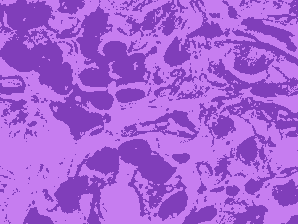



----- Compressed image for k =  3  -----
Iterations:  13
Time until convergence (secs):  10.205298900604248


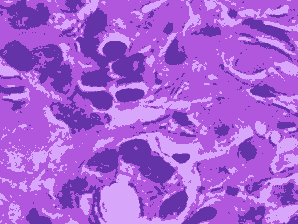



----- Compressed image for k =  4  -----
Iterations:  17
Time until convergence (secs):  17.113280057907104


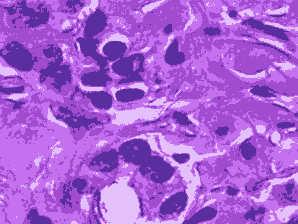



----- Compressed image for k =  5  -----
Iterations:  17
Time until convergence (secs):  21.576080083847046


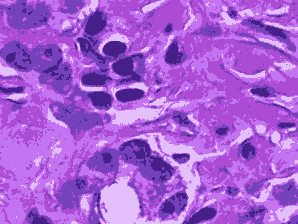



----- Compressed image for k =  6  -----
Iterations:  11
Time until convergence (secs):  17.449271202087402


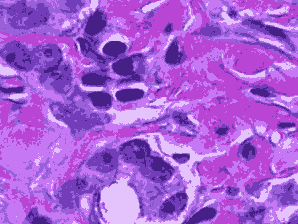

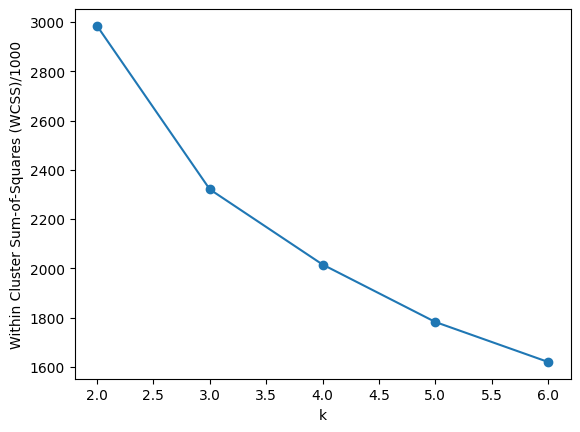

In [9]:
compress_img(img_path='data/hestain.bmp')



----- Compressed image for k =  2  -----
Iterations:  7
Time until convergence (secs):  16.03161597251892


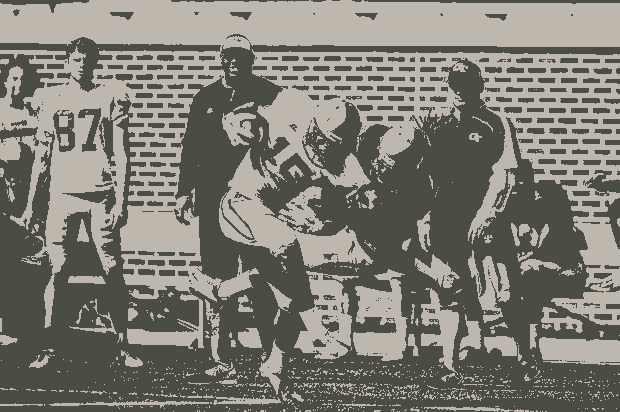



----- Compressed image for k =  3  -----
Iterations:  8
Time until convergence (secs):  26.430514812469482


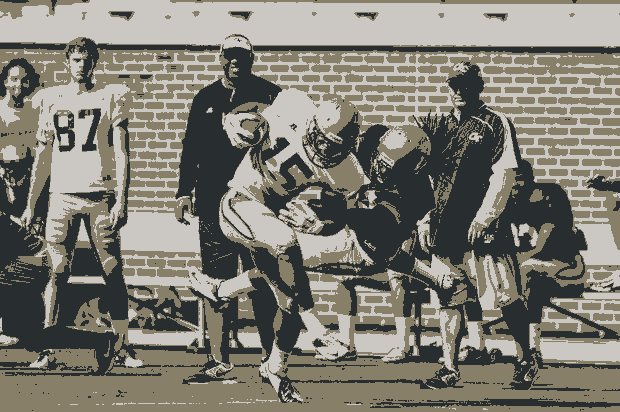



----- Compressed image for k =  4  -----
Iterations:  8
Time until convergence (secs):  34.918514251708984


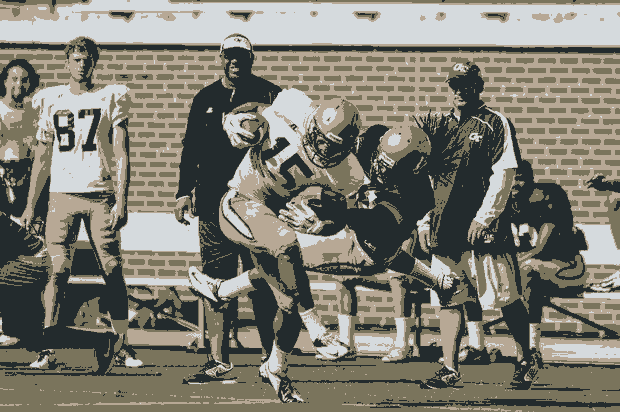



----- Compressed image for k =  5  -----
Iterations:  30
Time until convergence (secs):  139.96158695220947


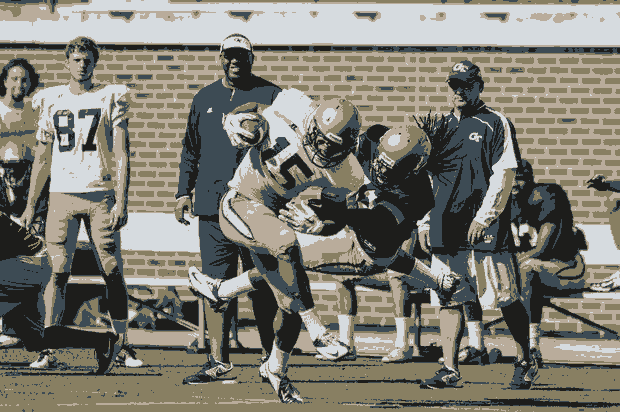



----- Compressed image for k =  6  -----
Iterations:  19
Time until convergence (secs):  112.50974297523499


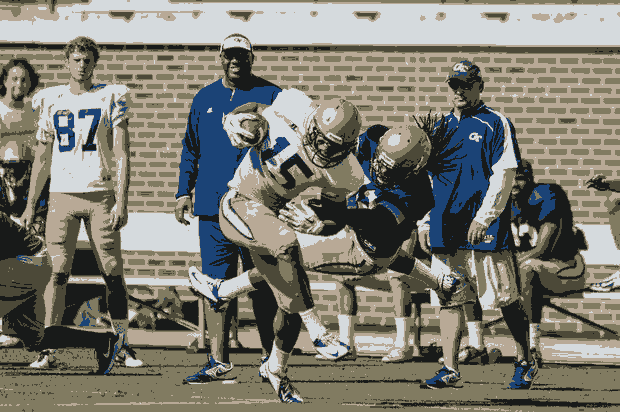

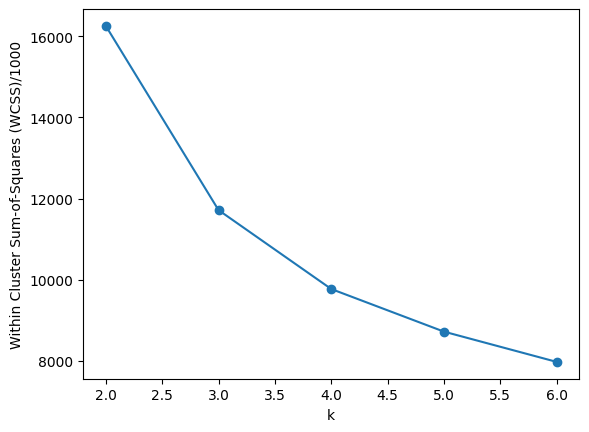

In [10]:
compress_img(img_path='data/football.bmp')



----- Compressed image for k =  2  -----
Iterations:  6
Time until convergence (secs):  23.59186887741089


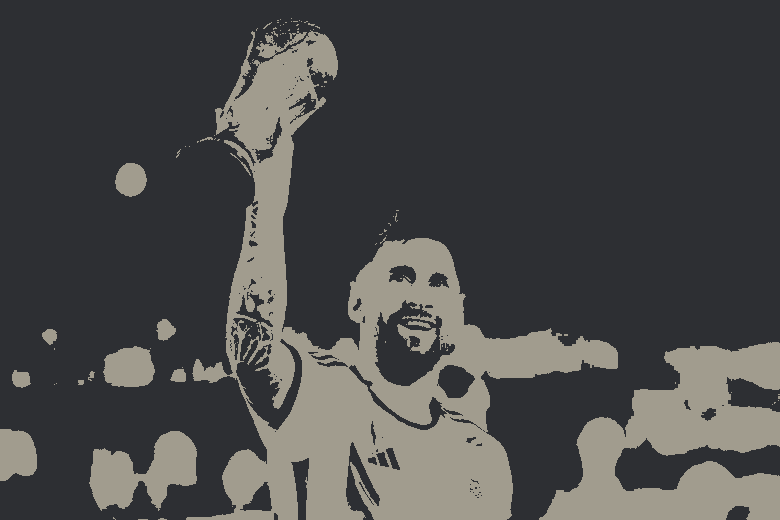



----- Compressed image for k =  3  -----
Iterations:  5
Time until convergence (secs):  29.82387685775757


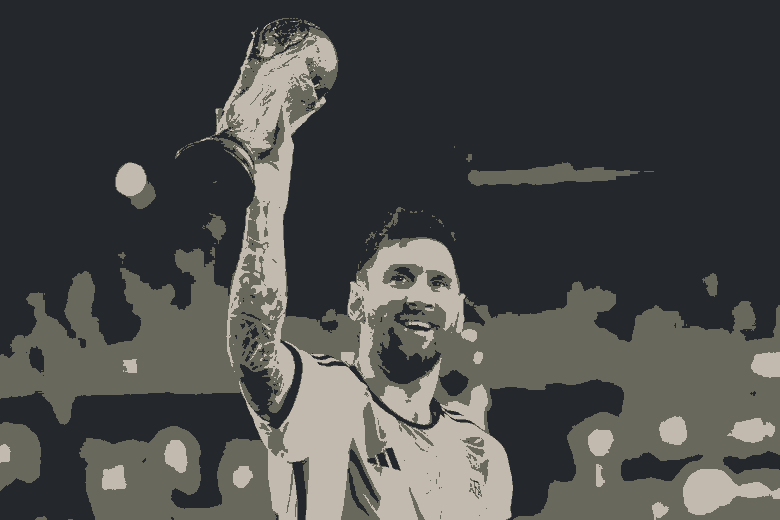



----- Compressed image for k =  4  -----
Iterations:  9
Time until convergence (secs):  62.43739318847656


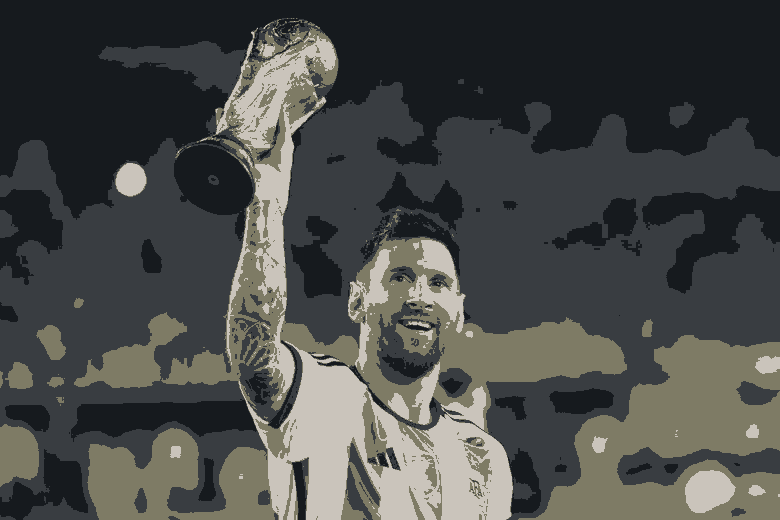



----- Compressed image for k =  5  -----
Iterations:  14
Time until convergence (secs):  113.01866698265076


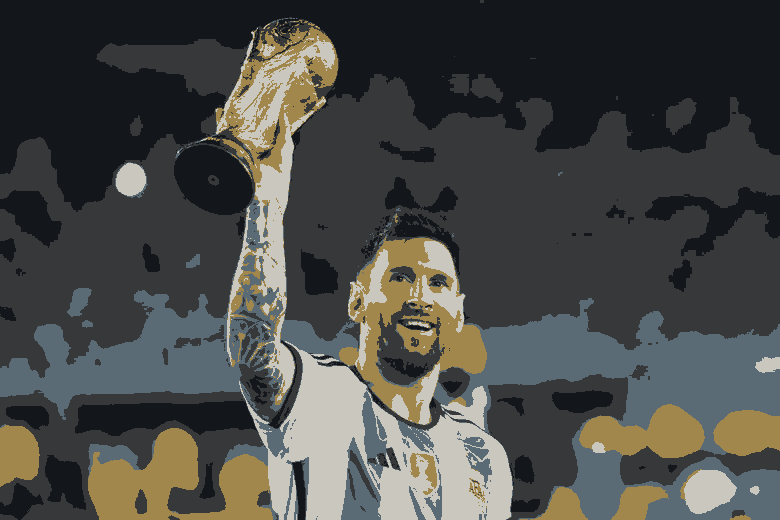



----- Compressed image for k =  6  -----
Iterations:  24
Time until convergence (secs):  219.82876992225647


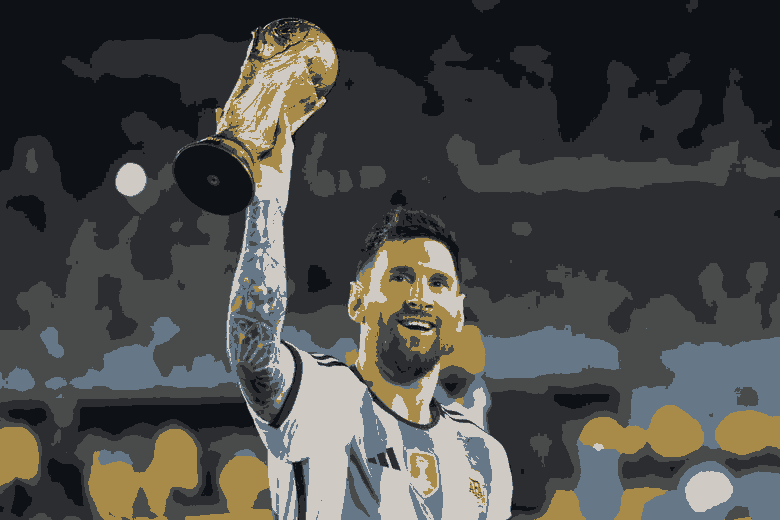

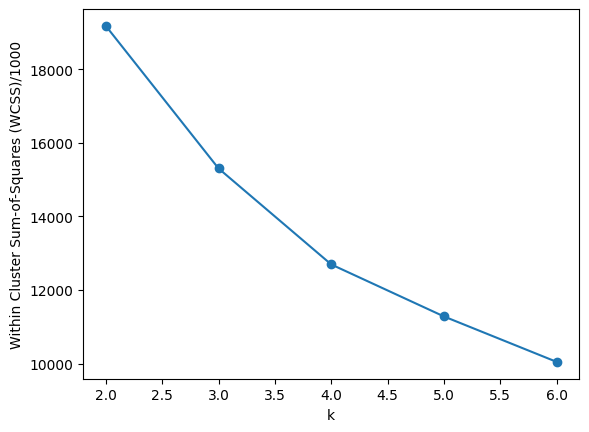

In [11]:
compress_img(img_path='data/worldcup.bmp')